In [73]:
# HIDDEN
from datascience import *
from datascience.predicates import are
import numpy as np
import matplotlib
matplotlib.use('Agg', warn=False)
%matplotlib inline
import matplotlib.pyplot as plots
plots.style.use('fivethirtyeight')

def load_and_clean_table(url):
    """Loads a table about Marvel or DC comics from fivethirtyeight's
    GitHub repository, and cleans up a few formatting details."""
    tbl = Table.read_table(url)
    if "Year" in tbl.labels:
        tbl.relabel("Year", "YEAR")
        tbl.update({'PUBLISHER': 'Marvel'})
    else:
        tbl.update({'PUBLISHER': 'DC'})
    tbl.relabel("name", "NAME")
    tbl.update({"APPEARANCES": np.nan_to_num(tbl.column("APPEARANCES"))})
    tbl.update({"GENDER": np.char.replace(tbl.column("SEX"), "nan", "Unknown")})
    tbl.update({"GENDER": np.char.replace(tbl.column("GENDER"), " Characters", "")})
    
    def extract_month(date_text):
        import dateutil.parser
        try:
            return dateutil.parser.parse(date_text).month
        except:
            return "Unknown"
    
    tbl.update({"MONTH": tbl.apply(extract_month, "FIRST APPEARANCE")})
    tbl.update({"MONTH": tbl.apply(lambda d: int(d) if d != "Unknown" else -1, "MONTH")})
    tbl = tbl.select("PUBLISHER", "NAME", "GENDER", "APPEARANCES", "YEAR", "MONTH")
    for l in tbl.labels:
        tbl.relabel(l, l.capitalize())
    tbl = tbl.where(~np.isnan(tbl.column("Year")))
    return tbl

In [74]:
# HIDDEN
# Load datasets from FiveThirtyEight about comics (again):

marvel_url = "https://github.com/fivethirtyeight/data/raw/master/comic-characters/marvel-wikia-data.csv"
dc_url = "https://github.com/fivethirtyeight/data/raw/master/comic-characters/dc-wikia-data.csv"

marvel = load_and_clean_table(marvel_url)
dc = load_and_clean_table(dc_url)

We will examine how the gender balance among characters evolved over time.  Before using a dataset to answer any complicated question, it's important to do more basic explorations to understand what's in the dataset.  Let's first look at the number of new characters overall.

In [75]:
print("There were {:d} Marvel characters and {:d} DC characters.".format(
                  marvel.num_rows,           dc.num_rows))

There were 15561 Marvel characters and 6827 DC characters.


Instead of printing out these numbers, we can make a bar chart:

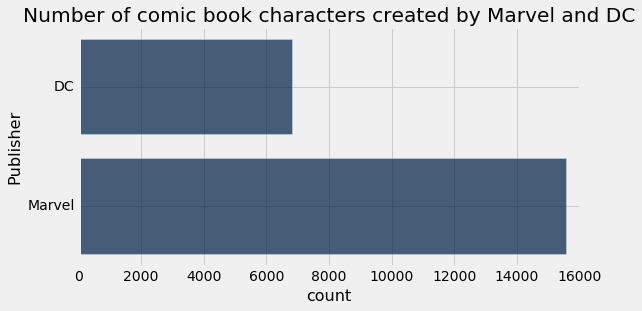

In [76]:
all_comics = marvel.copy().append(dc)
all_comics.group_barh("Publisher", width=8)
plots.title("Number of comic book characters created by Marvel and DC");

The bar chart conveys the same information in a picture rather than text.  Notice that your brain understands the ratio of DC characters to Marvel characters from the bar chart, apparently without any conscious arithmetic.

Now let us check the overall balance of genders.  First, we'll look at that information in another table.

In [77]:
all_comics.group("Gender")

Gender,count
Agender,36
Female,5575
Genderfluid,2
Genderless,20
Male,15835
Transgender,1
Unknown,919


Again, a bar chart is easier to read:

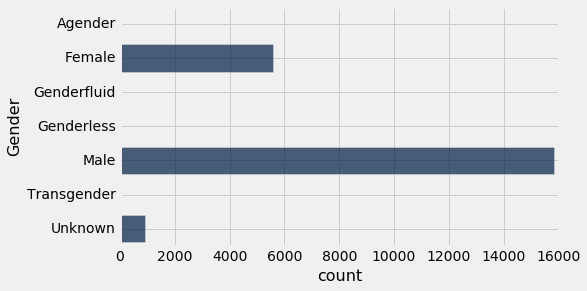

In [78]:
all_comics.group_barh("Gender", width=7)

There are more than twice as many male characters as female characters.

Visualization becomes more critical for comprehension as information becomes richer.  To compare gender representation in DC and Marvel, we could make a table similar to the one above:

In [79]:
all_comics.pivot("Publisher", "Gender")

Gender,DC,Marvel
Agender,0,36
Female,1947,3628
Genderfluid,0,2
Genderless,20,0
Male,4735,11100
Transgender,1,0
Unknown,124,795


However, a bar chart is more natural for comparing the larger categories:

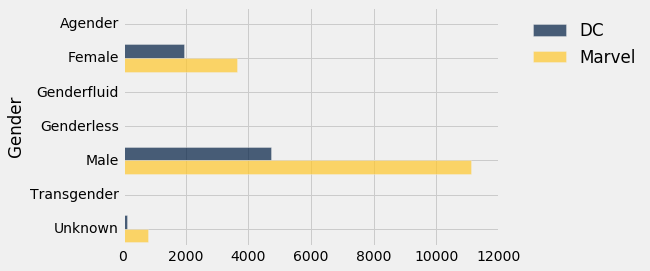

In [80]:
all_comics.pivot("Publisher", "Gender").barh("Gender")

Marvel has many more female characters, but DC has fewer characters overall.  If we want to know the *representation* of each gender, we should look at the numbers as a proportion of all characters from each publisher.  This is called *normalizing* the data.

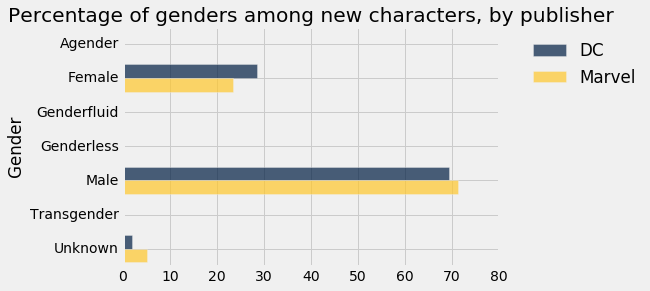

In [81]:
gender_by_publisher = all_comics.pivot("Publisher", "Gender")
gender_by_publisher.with_column("DC", 100*gender_by_publisher.column("DC") / sum(gender_by_publisher.column("DC")))\
                   .with_column("Marvel", 100*gender_by_publisher.column("Marvel") / sum(gender_by_publisher.column("Marvel")))\
                   .barh("Gender")
plots.title("Percentage of genders among new characters, by publisher");

Normalizing the data was important, and it will be important in considering our main question about change over time.  DC actually has more female characters than Marvel does, as a percentage of all its characters.  But both percentages are below 30%.

Finally, the representation of people in comic books depends not just on the number of characters but also on the role and prevalence of characters.  This dataset has some coarse information about how characters are portrayed - as villains or heroes, for example - and the number of times characters appeared.  Let us count how many times characters of each gender appeared.  Again, we will normalize by the total number of appearances.

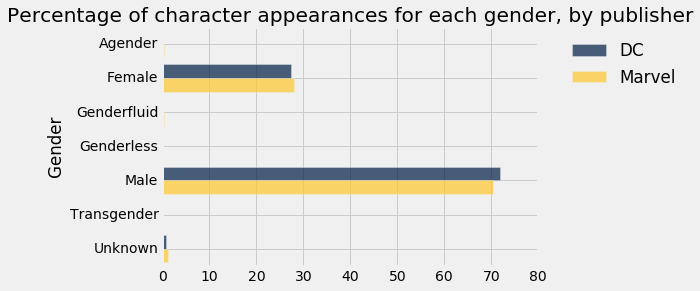

In [82]:
appearances = all_comics.pivot("Publisher", "Gender", "Appearances", sum)
dc_percentages = 100*appearances.column("DC") / sum(appearances.column("DC"))
marvel_percentages = 100*appearances.column("Marvel") / sum(appearances.column("Marvel"))
appearances.with_column("DC", dc_percentages)\
           .with_column("Marvel", marvel_percentages)\
           .barh("Gender")
plots.title("Percentage of character appearances for each gender, by publisher");

Comparing this chart to the previous one, we see that appearance rates don't seem to make much difference.  For simplicity, we will ignore them.

Before we finish our exploration, we should notice an important problem with the bar chart visualizations: the rarer categories are so small that their bars appear empty.  In some ways this is accurate, since there have been vanishingly few transgender or agender characters in comic books.  But the tables show that the numbers are not 0; there are 36 agender Marvel characters and 20 genderless DC characters.  (In fact, this also suggests that Marvel uses the term "agender" for characters who have no gender, while DC uses "genderless."  An analysis of representation of agender people would probably need to group those two categories together.)